In [96]:
# Set directories 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)
data_dir = os.path.join(os.getcwd(), '..', 'data')
output_dir = os.path.join(os.getcwd(), '..', 'output')


# Import Functions
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from plotnine import ggplot, aes, facet_grid, labs, scale_x_discrete,geom_point,scale_color_gradient, coord_flip,scale_fill_gradient,geom_bar,scale_x_continuous,scale_fill_manual,geom_histogram,theme_bw,geom_boxplot

df= pd.read_csv(data_dir + "/listings.csv")

Question: Can we predict the price of a listing and what are the most important factors influencing the price.

I guess that this will definetly depend from the location as well as from the size and quality of the location. Also the host could have an influence

# Data Understanding 

There are in total 3818 rows and 92 different varaiables in the listings data.frame

In [28]:
df.shape

(3818, 92)

In [29]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Besides the daily price for a listing the dataframe also contains weekly and mothly prices. I am interested in predicting the daily price. The price is never missing so in all cases we have a target variable

In [30]:
df.price.isnull().sum()

0

Just as with also the other dataframe the Dollar sign has to be replaced and the column has to be converted to numeric

In [31]:
df["price"] = df["price"].replace({'\$': '', ',': ''}, regex=True)
df["price"] = pd.to_numeric(df['price'])

Lets take a closer look at the variables in the dataframe

In [32]:
pd.options.display.max_columns = 500
df.sample(n=10)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1933,3582883,https://www.airbnb.com/rooms/3582883,20160104002432,2016-01-04,Room A Easiest Commute in town,Warm and Quite. Easiest commute in town - From...,Most easy commute location in town. Warm and s...,Warm and Quite. Easiest commute in town - From...,none,NaN,NaN,"Every 7 minute the ""Link"" go to airport or dow...",https://a1.muscache.com/ac/pictures/45162715/9...,https://a1.muscache.com/im/pictures/45162715/9...,https://a1.muscache.com/ac/pictures/45162715/9...,https://a1.muscache.com/ac/pictures/45162715/9...,15984289,https://www.airbnb.com/users/show/15984289,Julian,2014-05-26,"Seattle, Washington, United States","Love to meeting peoples.\r\nSemi-retire, live ...",within an hour,100%,100%,f,https://a0.muscache.com/ac/users/15984289/prof...,https://a0.muscache.com/ac/users/15984289/prof...,North Beacon Hill,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"South Alaska Place, Seattle, WA 98108, United ...",North Beacon Hill,Mid-Beacon Hill,Beacon Hill,Seattle,WA,98108,Seattle,"Seattle, WA",US,United States,47.560769,-122.294315,t,House,Private room,2,2.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,Heating,...",NaN,55.0,NaN,NaN,NaN,$10.00,1,$0.00,1,1125,3 weeks ago,t,27,57,87,358,2016-01-04,93,2014-07-26,2015-12-20,91.0,10.0,9.0,10.0,9.0,9.0,9.0,f,NaN,WASHINGTON,f,moderate,f,f,5,5.28
1791,1000883,https://www.airbnb.com/rooms/1000883,20160104002432,2016-01-04,Charming Admiral District Cottage,Located in West Seattle's Admiral neighborhood...,Located in West Seattle's fabulous Admiral nei...,Located in West Seattle's Admiral neighborhood...,none,The Admiral District has several great grocery...,The cottage was newly built in 2009 and has in...,A short 2-minute walk to the water taxi shuttl...,https://a2.muscache.com/ac/pictures/20451182/4...,https://a2.muscache.com/im/pictures/20451182/4...,https://a2.muscache.com/ac/pictures/20451182/4...,https://a2.muscache.com/ac/pictures/20451182/4...,5486919,https://www.airbnb.com/users/show/5486919,Nicole,2013-03-16,"Seattle, Washington, United States",I live in Seattle with 6-year-old daughter. Ga...,within a few hours,86%,100%,f,https://a1.muscache.com/ac/users/5486919/profi...,https://a1.muscache.com/ac/users/5486919/profi...,North Admiral,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Southwest Waite Street, Seattle, WA 98116, Uni...",North Admiral,North Admiral,West Seattle,Seattle,WA,98116,Seattle,"Seattle, WA",US,United States,47.580449,-122.396871,t,House,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,100.0,$700.00,"$2,800.

# Data Preparation

There is a lot of interesting information in text columns. Information such as description, summary, space could offer us valuable information about the place. Nevertheless I am going to start with some easier more basic features:

- host_since
- host_response_time
- host_is_superhost
- host_response_rate
- host_acceptance_rate
- host_neighbourhood
- host_listings_count
- host_has_profile_pic
- host_identity_verified
- neighbourhood	/ neighbourhood_cleansed
- property_type	
- room_type	
- accommodates	
- bathrooms	
- bedrooms	
- beds	
- bed_type
- amenities	
- square_feet
- instant_bookable	

In the first step I also want to exclude the ratings of the host as I want to rather find out more about how location and the type of place influence the price


In [33]:
df_complete = df
df = df.loc[:,["id","price","last_scraped","host_since", "host_is_superhost"
               ,"host_listings_count"
               ,"host_has_profile_pic","host_identity_verified","neighbourhood_cleansed"
               ,"property_type","room_type","accommodates","bathrooms","bedrooms","beds","bed_type"
               ,"amenities","square_feet","instant_bookable"]]


               


The variable square feet is missing in over 97 percent of the cases. Thus it is going to be dropped 

In [34]:
df.isnull().sum() / df.shape[0]

id                        0.000000
price                     0.000000
last_scraped              0.000000
host_since                0.000524
host_is_superhost         0.000524
host_listings_count       0.000524
host_has_profile_pic      0.000524
host_identity_verified    0.000524
neighbourhood_cleansed    0.000000
property_type             0.000262
room_type                 0.000000
accommodates              0.000000
bathrooms                 0.004191
bedrooms                  0.001572
beds                      0.000262
bed_type                  0.000000
amenities                 0.000000
square_feet               0.974594
instant_bookable          0.000000
dtype: float64

In [35]:
df = df.drop("square_feet",1)

Host since is in date format and needs to be converted to a number. I am going to calculate the number of days between this last scraping and since when the host started

In [36]:
df["host_since"] = pd.to_datetime(df.host_since, format='%Y-%m-%d')
df["last_scraped"] = pd.to_datetime(df.last_scraped, format='%Y-%m-%d')
df["host_since_num"] = (df.last_scraped - df.host_since).dt.days
df = df.drop(columns = ["last_scraped","host_since"])



With a look at the data we can see that a few columns we expect to be numeric still are of type object. A look at the data also tells us that amenities different values have been saved in the amneties column still have to be separated into dummy columns so that the model can make use of it. 

In [37]:
df.dtypes

id                          int64
price                     float64
host_is_superhost          object
host_listings_count       float64
host_has_profile_pic       object
host_identity_verified     object
neighbourhood_cleansed     object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
bed_type                   object
amenities                  object
instant_bookable           object
host_since_num            float64
dtype: object

In [38]:
df

,id,price,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,instant_bookable,host_since_num
0,241032,85.0,f,3.0,t,t,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",f,1607.0
1,953595,150.0,t,6.0,t,t,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",f,1047.0
2,3308979,975.0,f,2.0,t,t,West Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",f,571.0
3,7421966,100.0,f,1.0,t,t,West Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",f,789.0
4,278830,450.0,f,2.0,t,t,West Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",f,1497.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,359.0,f,354.0,t,t,Fremont,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",f,266.0
3814,8902327,79.0,f,1.0,t,t,Portage Bay,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",f,82.0
3815,10267360,93.0,f,1.0,t,f,Rainier Beach,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",f,5.0
3816,9604740,99.0,f,1.0,t,t,Madison Park,Condominium,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",f,366.0


In [41]:
# not needed anymore since host_reponse_rate not used
#for col in ["host_response_rate","host_acceptance_rate"]:
#    df[col] = pd.to_numeric(df[col].replace({'\%': ''}, regex=True))


Check correlation to drop to correlated features for the linear model 

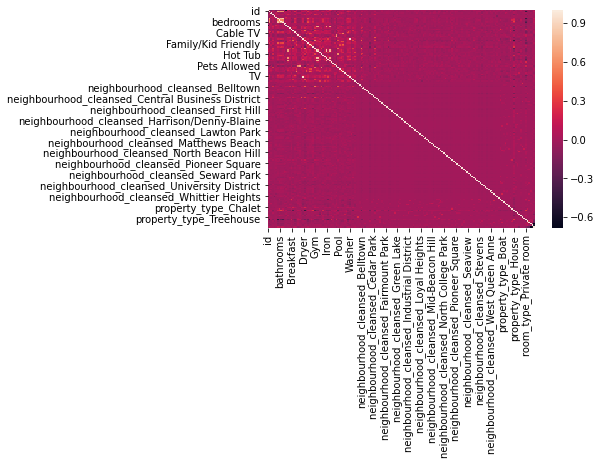

In [53]:
import seaborn as sns
corr= df.select_dtypes(exclude='object').corr()
sns.heatmap(corr)
high_corr_features = ["bathrooms","bedrooms","beds"]

Have a look at amenities to decide how we can make the column numeric

In [43]:
df.amenities[1]

'{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}'

In [44]:
df_amenities = df.amenities.replace({'\"|\{|\}' : ''}, regex=True).str.get_dummies(sep=',',)
df_amenities.drop("Kitchen",1)            

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet(s),Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1
2,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1
3,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1
4,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0,1,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1
3814,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
3815,0,0,1,0,1,0,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1
3816,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [45]:
df_amenities

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet(s),Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1
2,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1
3,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1
4,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0,1,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1
3814,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
3815,0,0,1,0,1,0,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1
3816,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [46]:
df = df.drop("amenities",1)
df = pd.concat([df,df_amenities],axis=1)

Now also the other categorical variables still have to be coded as dummy variables. There are also other methods to deal with them but for the start I just want to dummy code them. When taking a closer look it is visible that there also some boolean variables which are still coded as characted. This has to be corrected

In [47]:
df.select_dtypes(include='object')

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bed_type,instant_bookable
0,f,t,t,West Queen Anne,Apartment,Entire home/apt,Real Bed,f
1,t,t,t,West Queen Anne,Apartment,Entire home/apt,Real Bed,f
2,f,t,t,West Queen Anne,House,Entire home/apt,Real Bed,f
3,f,t,t,West Queen Anne,Apartment,Entire home/apt,Real Bed,f
4,f,t,t,West Queen Anne,House,Entire home/apt,Real Bed,f
...,...,...,...,...,...,...,...,...
3813,f,t,t,Fremont,House,Entire home/apt,Real Bed,f
3814,f,t,t,Portage Bay,Apartment,Entire home/apt,Real Bed,f
3815,f,t,f,Rainier Beach,House,Entire home/apt,Real Bed,f
3816,f,t,t,Madison Park,Condominium,Entire home/apt,Real Bed,f


In [48]:
dict_booleans = {
    "f": 0,
    "t": 1
}

for col in ["host_is_superhost","host_has_profile_pic","host_identity_verified","instant_bookable"]:
    df[col] = df[col].map(dict_booleans)


In [49]:
df_dummies = pd.get_dummies(df.select_dtypes(include='object'),drop_first=True)
df = pd.concat([df.select_dtypes(exclude='object'),df_dummies],axis=1)

The new dataframe now has 165 columns. The last probleming before modeling the data is to treat the remaining missing values. Here we will choose the simple method of just replacing them with the mean of each column

In [50]:
df.iloc[:,0:20].isnull().sum()

id                           0
price                        0
host_is_superhost            2
host_listings_count          2
host_has_profile_pic         2
host_identity_verified       2
accommodates                 0
bathrooms                   16
bedrooms                     6
beds                         1
instant_bookable             0
host_since_num               2
24-Hour Check-in             0
Air Conditioning             0
Breakfast                    0
Buzzer/Wireless Intercom     0
Cable TV                     0
Carbon Monoxide Detector     0
Cat(s)                       0
Dog(s)                       0
dtype: int64

In [51]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

The first thing is to separate the data into test and training sets. Here I am goint to use a simple split without any cross validation.

In [55]:
df = df.loc[ (df.price < 500) & (df.price > 40),:]
df = df.drop(columns = high_corr_features,axis=1)

X = df.drop("price",1)
y = df["price"]

var_in_df = df.var().apply(lambda x: '%.5f' % x)
sum(X.var() > 0.01)

X = X.loc[:,X.var() > 0.01]
X = X.drop("id",1)

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

Now the model has to be fitted and can then be  applied to the test_data. The results of the data shows that the fit is not very good. The Rsquared is negative and thus the model is worse than just taking the mean of the target. 

# Modeling (and evaluation)

In [93]:
clf = Lasso(alpha=0.2,normalize=True)
clf.fit(X_train,np.log(y_train))
pred_test = clf.predict(X_test)

r2_score(y_test,np.exp(pred_test))

-0.047479804048703445

Instead I am going to try a Random Forest Classifier. The result is already a lot better than the Linear Model. 

In [57]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)



/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [58]:
r2_score(y_test,y_test_preds)

0.5819313650573608

Now the feature importance is going to be investigated

In [59]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": forest.feature_importances_
})

In [79]:
importance_df_top20 = importance_df.sort_values("Importance",ascending=False).reset_index(drop=True).loc[0:20,:]
importance_df_top20


,Feature,Importance
0,accommodates,0.423767
1,host_since_num,0.082225
2,room_type_Private room,0.066008
3,host_listings_count,0.029594
4,Elevator in Building,0.015521
5,Indoor Fireplace,0.015470
6,Cable TV,0.011958
7,property_type_House,0.011107
8,Family/Kid Friendly,0.010575
9,Doorman,0.010143


In [86]:
importance_df_top20["Feature"].tolist()

['Shampoo',
 'Carbon Monoxide Detector',
 'TV',
 'Free Parking on Premises',
 'host_identity_verified',
 'neighbourhood_cleansed_Alki',
 'Air Conditioning',
 'neighbourhood_cleansed_Lower Queen Anne',
 'First Aid Kit',
 'neighbourhood_cleansed_West Queen Anne',
 'Essentials',
 'Doorman',
 'Family/Kid Friendly',
 'property_type_House',
 'Cable TV',
 'Indoor Fireplace',
 'Elevator in Building',
 'host_listings_count',
 'room_type_Private room',
 'host_since_num',
 'accommodates']

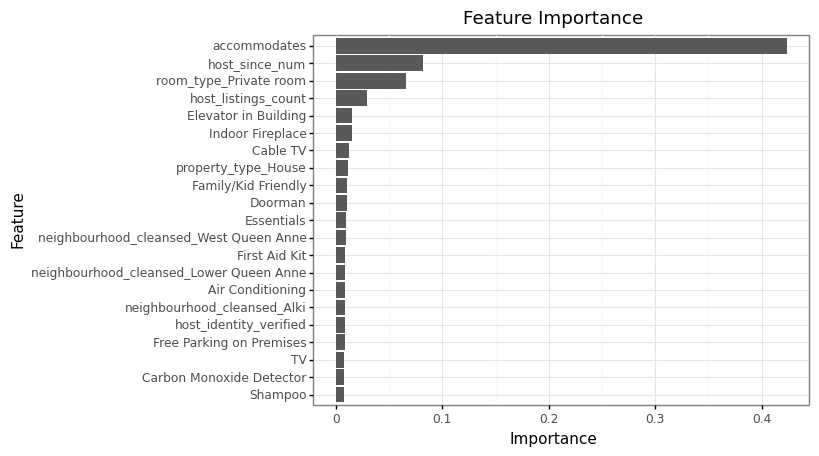

<ggplot: (-9223372036534676778)>

In [87]:
importance_plot = (ggplot(importance_df_top20)+
    aes(x= "Feature",y= "Importance") + 
    geom_bar(stat = "identity") +
    theme_bw() +
    labs(x="Feature",y = "Importance",title = "Feature Importance Top 20") +
    scale_x_discrete(limits=importance_df_top20["Feature"].tolist()[::-1]) +
    coord_flip()
)
importance_plot

In [97]:
importance_plot.save(filename = os.path.join(output_dir,"ImportancePlotRandomForest.png"))

/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/matthiaslenfers/code/DSBlogPostUdacity/notebooks/../output/ImportancePlotRandomForest.png


In [71]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=150, learning_rate= 0.05,subsample = 0.6,
     max_depth=7, random_state=0)
gbr.fit(X_train,y_train)
pred_test = gbr.predict(X_test)
r2_score(y_test,pred_test)


0.5822853358190073

In [91]:
importance_df_gbr = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gbr.feature_importances_
})

In [94]:
importance_df_gbr.sort_values("Importance",ascending=False).reset_index(drop=True).loc[0:20,:]

,Feature,Importance
0,accommodates,0.189305
1,host_since_num,0.154317
2,host_listings_count,0.045785
3,room_type_Private room,0.023074
4,Indoor Fireplace,0.020377
5,property_type_House,0.016396
6,Cable TV,0.015004
7,Essentials,0.014594
8,host_identity_verified,0.013823
9,Family/Kid Friendly,0.013553
